In [121]:
import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

In [122]:
# Read the data into a DataFrame
mini_emails_df = pd.read_csv('emails.csv', nrows = 500)
print(mini_emails_df.shape)
mini_emails_df.head()

(500, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [123]:
print(mini_emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [124]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [125]:
help(email)

Help on package email:

NAME
    email - A package for parsing, handling, and generating email messages.

MODULE REFERENCE
    https://docs.python.org/3.6/library/email
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

PACKAGE CONTENTS
    _encoded_words
    _header_value_parser
    _parseaddr
    _policybase
    base64mime
    charset
    contentmanager
    encoders
    errors
    feedparser
    generator
    header
    headerregistry
    iterators
    message
    mime (package)
    parser
    policy
    quoprimime
    utils

FUNCTIONS
    message_from_binary_file(fp, *args, **kws)
        Read a binary file and parse its contents into a Message object model.
        
        Optional _class and strict are passed 

In [126]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, mini_emails_df['message']))
mini_emails_df.drop('message', axis=1, inplace=True)
#print(messages)

In [127]:
print(type(messages[0]))
#help(email.message.Message)
print(messages[0])
messages[0].keys()
#print(messages[0].items())
#mini_emails_df['file']

<class 'email.message.Message'>
Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [128]:
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    mini_emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
mini_emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
mini_emails_df['From'] = mini_emails_df['From'].map(split_email_addresses)
mini_emails_df['To'] = mini_emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
mini_emails_df['user'] = mini_emails_df['file'].map(lambda x:x.split('/')[0])
del messages

mini_emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [129]:
print('shape of the dataframe:', mini_emails_df.shape)
# Find number of unique values in each columns
for col in mini_emails_df.columns:
    print(col, mini_emails_df[col].nunique())

shape of the dataframe: (500, 18)
file 500
Message-ID 500
Date 491
From 2
To 177
Subject 260
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 2
X-From 2
X-To 230
X-cc 14
X-bcc 1
X-Folder 3
X-Origin 1
X-FileName 2
content 500
user 1


In [130]:
# Set index and drop columns with two few values
mini_emails_df = mini_emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [131]:
mini_emails_df.keys()
#mini_emails_df.shape

Index(['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-cc', 'X-bcc',
       'X-Folder', 'X-Origin', 'X-FileName', 'content', 'user'],
      dtype='object')

In [132]:
mini_emails_df['Date'][0]

'Mon, 14 May 2001 16:39:00 -0700 (PDT)'

In [133]:
#mini_day = pd.DataFrame(mini_emails_df['Date'].map(lambda x:x.split(',')),columns=['day_of_week','date'])
#mini_emails_df['Date'] = mini_emails_df['Date'].map(lambda x:x.split(', ')[1])

In [134]:
#mini_emails_df['Date'][0]

In [138]:
#mini_emails_df['Date'] = pd.to_datetime(mini_emails_df['Date'], format='%w, %d %m %Y %H:%M:%S %z',infer_datetime_format=True)
mini_emails_df['Date'] = pd.to_datetime(mini_emails_df['Date'],infer_datetime_format=True,utc=True)
mini_emails_df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

In [137]:
help(pd.to_datetime)

Help on function to_datetime in module pandas.core.tools.datetimes:

to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, box=True, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=False)
    Convert argument to datetime.
    
    Parameters
    ----------
    arg : integer, float, string, datetime, list, tuple, 1-d array, Series
    
        .. versionadded:: 0.18.1
    
           or DataFrame/dict-like
    
    errors : {'ignore', 'raise', 'coerce'}, default 'raise'
    
        - If 'raise', then invalid parsing will raise an exception
        - If 'coerce', then invalid parsing will be set as NaT
        - If 'ignore', then invalid parsing will return the input
    dayfirst : boolean, default False
        Specify a date parse order if `arg` is str or its list-likes.
        If True, parses dates with the day first, eg 10/11/12 is parsed as
        2012-11-10.
        with day first (this is a known bug, based on dateutil

# explorer

Text(0, 0.5, 'N emails')

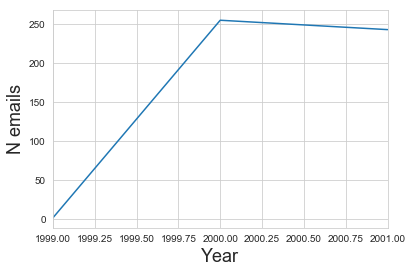

In [139]:
ax = mini_emails_df.groupby(mini_emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

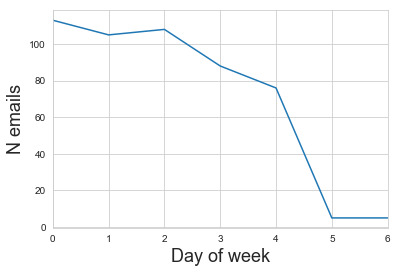

In [141]:
ax = mini_emails_df.groupby(mini_emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)


Text(0, 0.5, 'N emails')

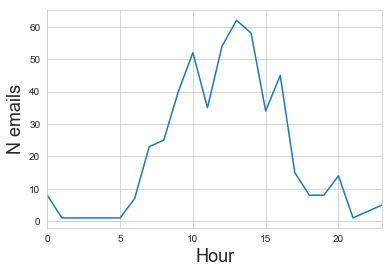

In [143]:
ax = mini_emails_df.groupby(mini_emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
tfidf_vectorizer = TfidfVectorizer()
#count_vectorizer = CountVectorizer()
X_tf = tfidf_vectorizer.fit_transform(mini_emails_df['content'])
#count_tf = count_vectorizer.fit_transform(mini_emails_df['content'])

In [214]:
idf = pd.DataFrame(data=X_tf.toarray(),columns=tfidf_vectorizer.get_feature_names())
idf = idf.T
max_df = pd.DataFrame(data=idf.max())
max_df.shape
#print(sorted(idf.max()),columns=tfidf_vectorizer.get_feature_names())

(500, 1)

In [217]:
sort_max = max_df.sort_values(inplace= max_df.get_values)
print(sort_max)

TypeError: sort_values() missing 1 required positional argument: 'by'

In [175]:
print(X_tf.shape)

(500, 6813)


In [161]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : string {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw content to analyze.
 |  
 |      If 'file', the sequence items must have a 'read' method (file-like
 |      object) that is called to fetch the bytes in memory.
 |  
 |      Otherwise the input is expected to be the sequence strings or
 |      bytes items are expected to be analyzed directly.
 |  
 |  encoding : string, 'utf-8' by default.
 |      If bytes or files are given to analyze, this encoding is used

           00       000  000000000000935  000000000001282  000000000021442  \
0    0.000000  0.000000              0.0              0.0              0.0   
1    0.000000  0.000000              0.0              0.0              0.0   
2    0.000000  0.000000              0.0              0.0              0.0   
3    0.000000  0.000000              0.0              0.0              0.0   
4    0.000000  0.000000              0.0              0.0              0.0   
5    0.000000  0.000000              0.0              0.0              0.0   
6    0.000000  0.000000              0.0              0.0              0.0   
7    0.000000  0.000000              0.0              0.0              0.0   
8    0.000000  0.000000              0.0              0.0              0.0   
9    0.000000  0.000000              0.0              0.0              0.0   
10   0.000000  0.000000              0.0              0.0              0.0   
11   0.000000  0.000000              0.0              0.0       